In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
import io
import xarray as xr
import pickle

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [2]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [117]:
fshear = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors.p', "rb"))
ftcw = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors.p', "rb"))

shearfac = fshear['obs_shear'] #0.71 # monthly: 0.55
tcwvfac_all =  ftcw['rel'] 

tcabsfac = np.mean(ftcw['abs']) #1.21 # absolute change

tcabserr = np.std(ftcw['abs']) #0.06 #mm h
tcrelerr = np.std(ftcw['rel']) #0.18 #%


In [114]:
ftcw.keys()

dict_keys(['rel', 'abs', 'futslope', 'histslope', 'futinter', 'histinter', 'tcw_hist', 'prcp_hist'])

In [ ]:
ftcw

In [ ]:
print(fshear.keys())
print(ftcw.keys())

In [5]:
tcwvfac

1.2855289971318293

In [6]:
tcabsfac

1.213483156330012

In [7]:
errperperc

NameError: name 'errperperc' is not defined

In [8]:
mmPerPercent

NameError: name 'mmPerPercent' is not defined

In [9]:
tcrelerr

0.12025016594416628

In [10]:
tcabserr

0.0813213566308613

In [11]:
base = '/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/'

dics = ['CP4hist', 'CP4fut', 'CP25hist', 'CP25fut']
cp4_read = {'period' : [], 'shear' : [], 'tcwv' : []}
for dd in dics:
   
    dic = pd.read_csv(base+dd+'_vars_DAILY.csv', index_col=0)
    #ipdb.set_trace()
    cp4_read['period'].append(dd)
    cp4_read['shear'].append(np.array(dic.loc['shear'])*-1)
    cp4_read['tcwv'].append(np.array(dic.loc['tcwv']))


In [12]:
cp4_read

{'period': ['CP4hist', 'CP4fut', 'CP25hist', 'CP25fut'],
 'shear': [array([13.122973]),
  array([16.145008]),
  array([12.626462]),
  array([14.523413])],
 'tcwv': [array([37.21887]),
  array([57.760437]),
  array([37.291157]),
  array([58.429615])]}

In [13]:
cp4_df = pd.DataFrame.from_dict(cp4_read)
cp4_df = cp4_df.set_index('period')

In [14]:
cp4_df.loc['CP4fut','shear']

array([16.145008])

In [83]:
cp4_shear_diff = (cp4_df.loc['CP4fut', 'shear']-cp4_df.loc['CP4hist', 'shear'])#/cp4_df.loc['CP4hist', 'shear']*100
cp25_shear_diff = (cp4_df.loc['CP25fut', 'shear']-cp4_df.loc['CP25hist', 'shear'])#/cp4_df.loc['CP25hist', 'shear']*100

cp4_tcwv_diff = (cp4_df.loc['CP4fut', 'tcwv']-cp4_df.loc['CP4hist', 'tcwv'])#/cp4_df.loc['CP4hist', 'tcwv']*100
cp25_tcwv_diff = (cp4_df.loc['CP25fut', 'tcwv']-cp4_df.loc['CP25hist', 'tcwv'])#/cp4_df.loc['CP25hist', 'tcwv']*100

cp4_historical_domainMean = cp4_df.loc['CP4hist', 'tcwv']
cp4_future_domainMean = cp4_df.loc['CP4fut', 'tcwv']

In [115]:
cp4_historical_domainMean

array([37.21887])

In [66]:
cp4 = '/home/ck/DIR/cornkle/figs/ENDGAME/lawrence/textfiles/impala_jas_mean_metrics_v02.txt'

In [67]:
base = '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/'
dics = [('2020-2050', '2030'), ('2030-2060', '2040'), ('2050-2080', '2060'), ('2070-2100', '2080')]
cmip_read = {}
for dd in dics:
    cmip_read[dd[1]] = pd.read_csv(base+dd[0]+'_CMIP.csv', index_col='model_name')
#     (cmip_read[dd[1]])['shear_mean_precip'] = (cmip_read[dd[1]])['shear_mean'] 
#     (cmip_read[dd[1]])['tcw_mean_precip'] = (cmip_read[dd[1]])['tcwv_mean'] 
#     (cmip_read[dd[1]])['shear_perc_'] = (cmip_read[dd[1]])['tcwv_mean'] 

In [68]:
cmip_read['2040']

,Unnamed: 0,shear_mean,tcw_mean,tcw_hist,shear_hist
model_name,,,,,
CESM1-CAM5,0,0.354096,6.857313,42.561478,13.936884
GFDL-CM3,1,1.569941,10.511845,33.617834,10.640636
IPSL-CM5A-MR,2,0.992621,8.764158,32.758006,11.925446
CNRM-CM5,3,0.500168,4.937510,38.379925,15.391787
ACCESS1-3,4,1.702665,8.680279,31.015336,3.963368
CMCC-CMS,5,0.587977,8.012296,39.857350,12.412925
CanESM2,6,1.412108,10.462126,39.239945,13.100850
NorESM1-ME,7,1.736083,7.047630,32.437198,10.004907
inmcm4,8,0.889028,3.129124,35.395468,14.311708


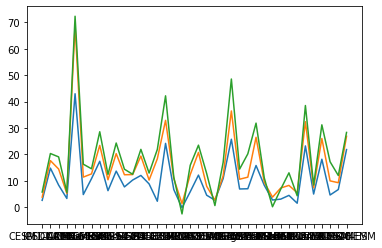

In [69]:
for y in ['2040','2060', '2080']:
    plt.plot(cmip_read[y]['shear_mean']/((cmip_read[y])['shear_hist'])*100)

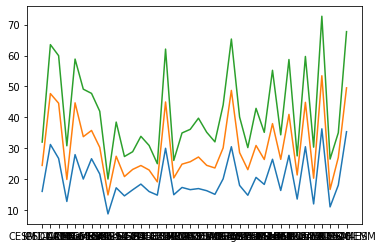

In [70]:
for y in ['2040','2060', '2080']:
    plt.plot(cmip_read[y]['tcw_mean']/((cmip_read[y])['tcw_hist'])*100)

In [122]:
(cmip_read['2040']).index[0]

'CESM1-CAM5'

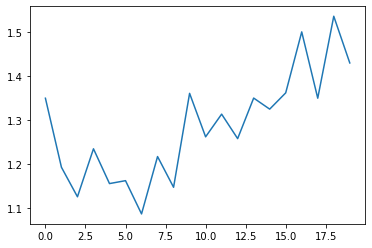

In [123]:
plt.plot(tcwvfac_all)

10,90 perc tcw model CSIRO-Mk3-6-0 BNU-ESM
10,90 perc tcw model GFDL-ESM2M CanESM2
10,90 perc tcw model GISS-E2-R CMCC-CMS


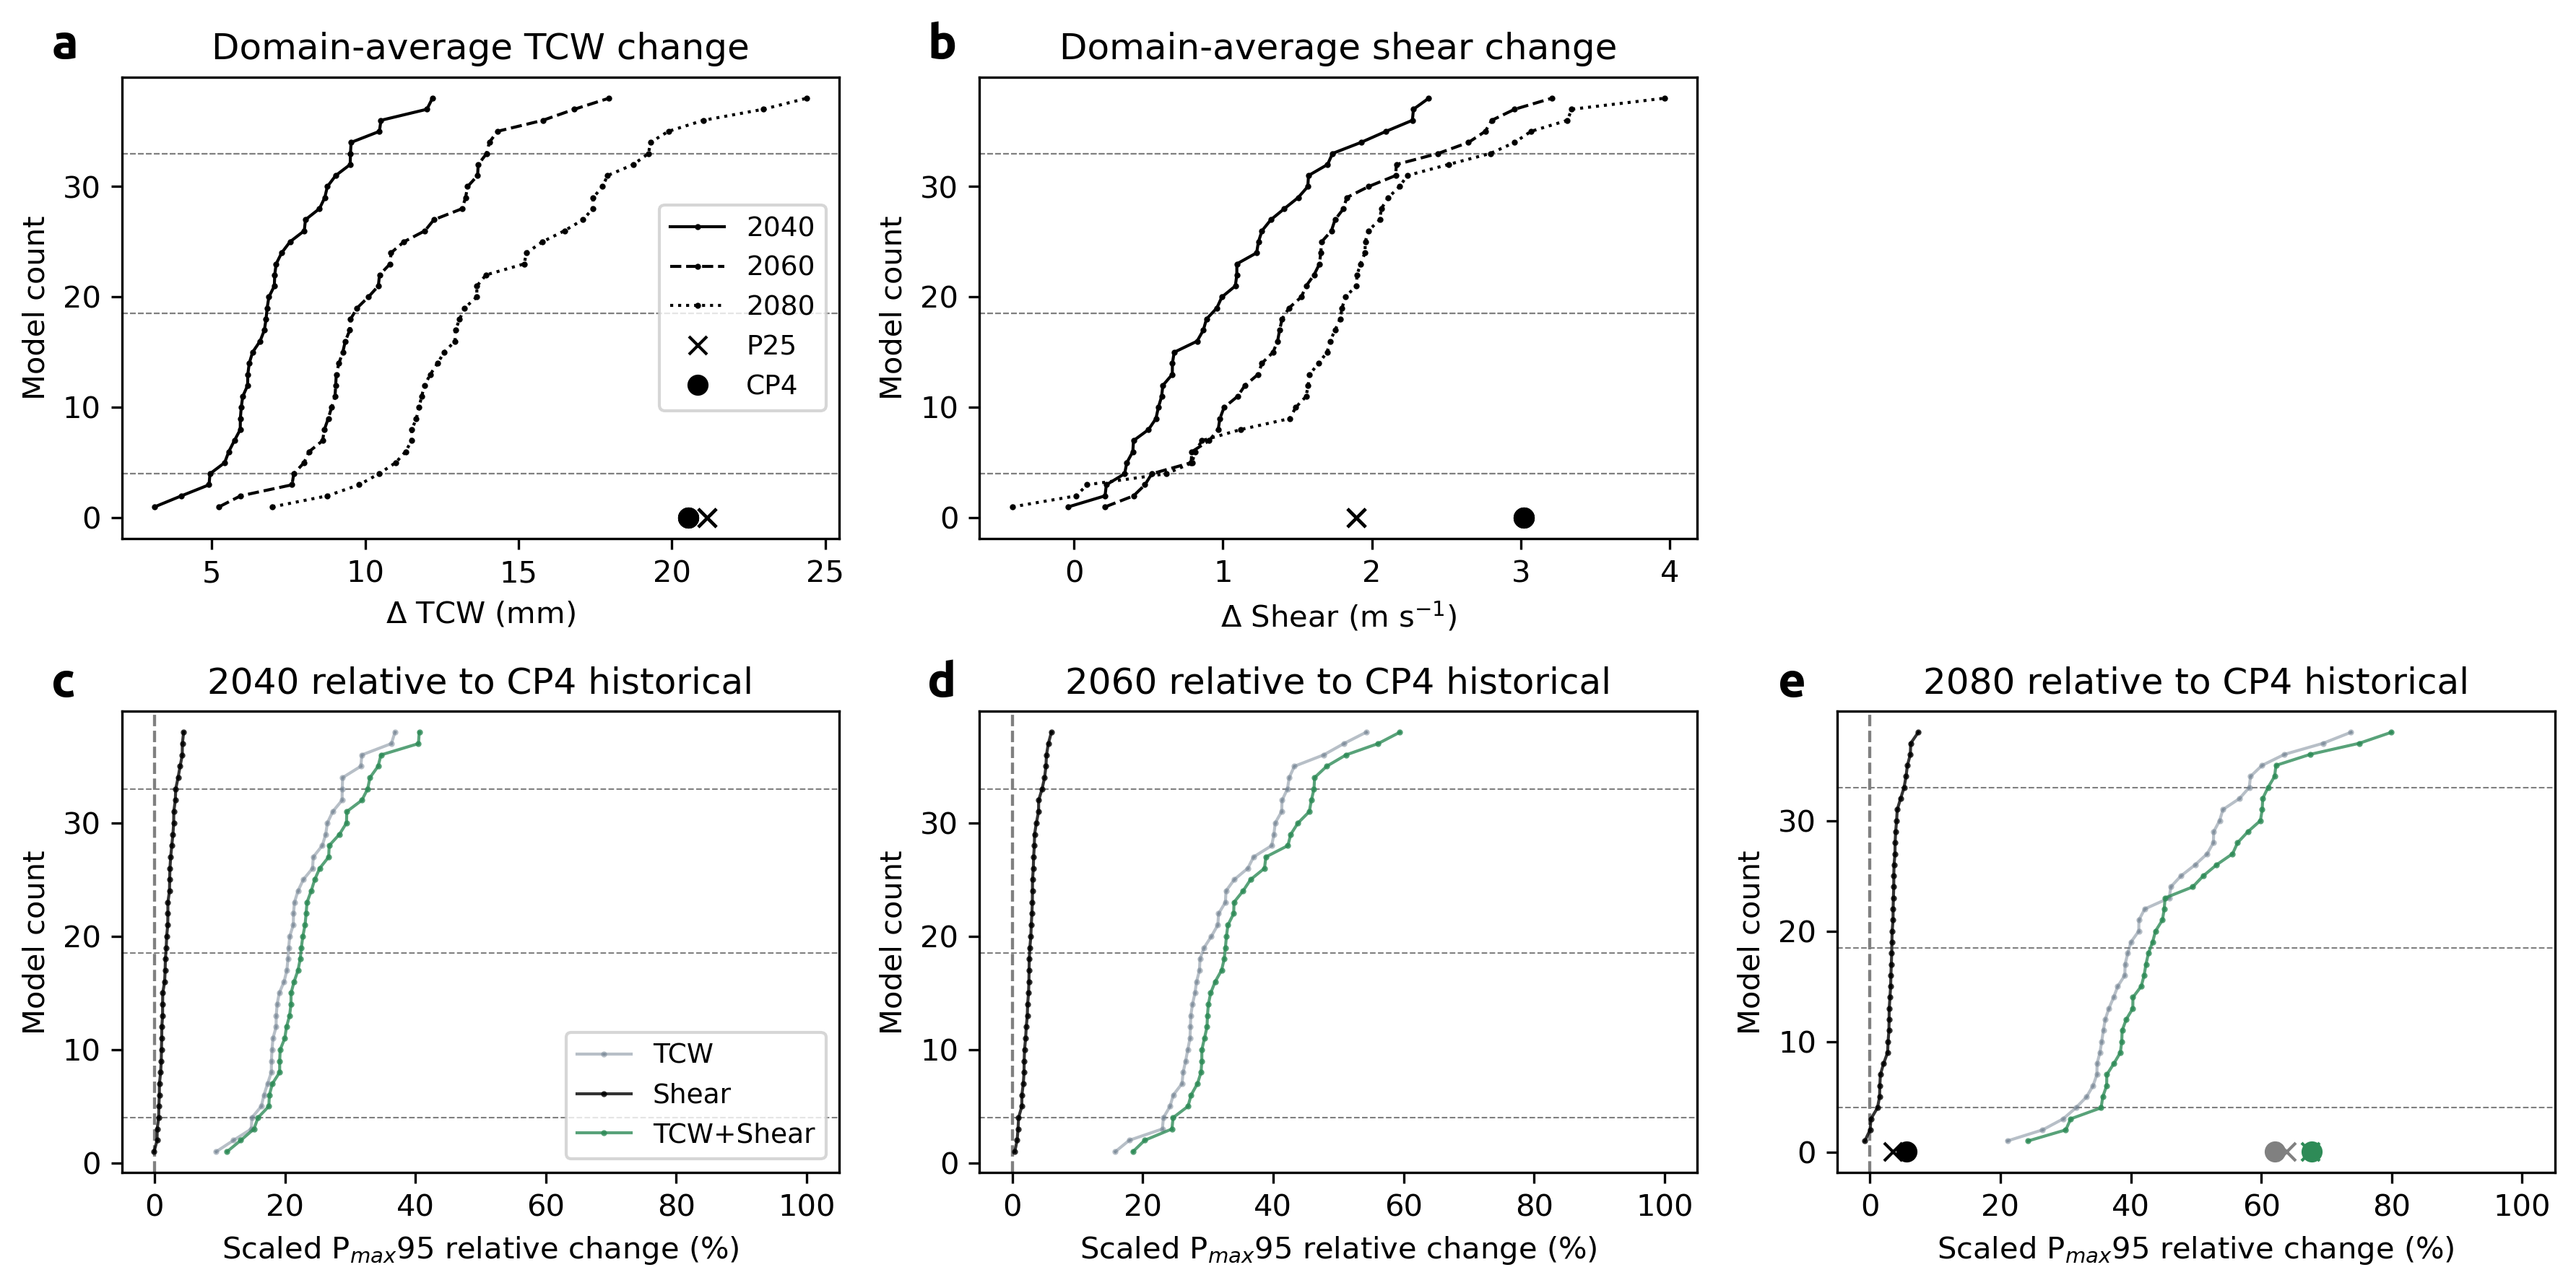

In [121]:
tcwvfac = tcwvfac_all[np.argmin(np.abs(cp4_historical_domainMean- ftcw['tcw_hist']))] #take tcw scaling for CP4 baseline tcw (37.2 mm domain wide) - it's the average scaling, where lower 
 
f = plt.figure(figsize=(12,6), dpi=300)
ax1 = f.add_subplot(2,3,1)
ax2 = f.add_subplot(2,3,2)

perc_dic = {}


linestyle = ['solid', 'dashed', 'dotted']
for ids, stry in enumerate(['2040', '2060', '2080']):
    

    ##########
    x = ((cmip_read[stry])['tcw_mean'])
    cmean = np.mean(x)
    cumulative = np.sort(x)
    posimean = np.argmin(np.abs(cmean-cumulative))

    ax1.plot(cumulative, np.arange(len(cumulative))+1, label=stry, marker='o', markersize=1, color='k', linestyle=linestyle[ids], linewidth=1)

    ax1.set_title(r'Domain-average TCW change')
    ax1.set_xlabel('$\Delta$ TCW (mm)')  #kg m$^{-2}$
    ax1.set_ylabel('Model count')


    x = (cmip_read[stry])['shear_mean']
    cumulative = np.sort(x)

    ax2.plot(cumulative, np.arange(len(cumulative))+1, label=stry, marker='o', markersize=1, color='k', linestyle=linestyle[ids], linewidth=1)
    
    ax2.set_title(r'Domain-average shear change')
    ax2.set_xlabel('$\Delta$ Shear (m s$^{-1}$)')
    ax2.set_ylabel('Model count')
    
    if ids == 2:

        ax1.plot(cp25_tcwv_diff,0.03, color='k', marker='x', label='P25', linestyle='')
        ax1.plot(cp4_tcwv_diff,0.03, color='k', marker='o', label='CP4', linestyle='')

        ax2.plot(cp25_shear_diff,0.03, color='k', marker='x', label='P25', linestyle='')
        ax2.plot(cp4_shear_diff,0.03, color='k', marker='o', label='CP4', linestyle='')
    else:
        
        
        ax1.plot(cp25_tcwv_diff,0.03, color='k', marker='x', linestyle='')
        ax1.plot(cp4_tcwv_diff,0.03, color='k', marker='o', linestyle='')

        ax2.plot(cp25_shear_diff,0.03, color='k', marker='x',  linestyle='')
        ax2.plot(cp4_shear_diff,0.03, color='k', marker='o',  linestyle='')
        
    ax1.axhline(18.5, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax1.axhline(4, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    #ax1.axhline(posimean, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax1.axhline(33, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    
    ax2.axhline(18.5, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax2.axhline(4, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax2.axhline(33, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    

    ax = f.add_subplot(2,3,ids+4)
    ##########
    ax.axhline(18.5, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax.axhline(4, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax.axhline(33, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    
    x = (cmip_read[stry])['tcw_mean']/cp4_historical_domainMean * tcwvfac *100 #/(cmip_read[stry])['tcw_hist']) * tcwvfac *100
    cumulative = np.sort(x)
    
    order = np.argsort(x)
    mnames = (cmip_read['2040']).index[order]
    
    cmip_p_from_shear = (cmip_read[stry]).shear_mean[order] *shearfac
    cmip_p_from_tcw = cp4_historical_domainMean*cumulative/100
    cmip_perc_per_mm = cumulative/cmip_p_from_tcw
    cmip_perc_shear = cmip_p_from_shear * cmip_perc_per_mm
    
    #ipdb.set_trace()
    
    cmip_shear_ordered = np.sort(cmip_perc_shear)
    cmip_total_ordered = np.sort(cumulative+cmip_perc_shear)
    
    #ipdb.set_trace()

    perc_num = np.arange(len((cmip_read[stry])['tcw_mean']))
    perc = np.round(np.percentile(perc_num, [10,90]),0).astype(int)
    
    print('10,90 perc tcw model', mnames[perc[0]], mnames[perc[-1]])
    perc_dic[stry] = {'tcw': (mnames[perc[0]], mnames[perc[-1]])}

    ax.plot(cumulative, np.arange(len(cumulative))+1, color='slategrey', alpha=0.5, label='TCW', marker='o', markersize=1, zorder=99, linewidth=1)

#     ax.axvline(0, linestyle='dashed', lw=1, color='grey')
#     ax.axhline(18.5, linestyle='dashed', lw=1, color='grey')

    ###
    #shplot = hist2d.basic_1d_binning(cmip_sh_precip['2080'].values, np.arange(np.min(cmip_sh_precip['2080']), np.max(cmip_sh_precip['2080']),0.1))
    #ax.bar(shplot['xbins'], shplot['nb']/np.sum(shplot['nb']), color='k', label='Shear', width=0.1)
    ##----
#     x = ((cmip_read[stry])['shear_mean']) * shearfac 
#     cumulative = np.sort(x)
    
#     order = np.argsort(x)
#     mnames = (cmip_read['2040']).index[order]
    
#     perc_num = np.arange(len((cmip_read[stry])['tcw_mean']))
#     perc = np.round(np.percentile(perc_num, [10,90]),0).astype(int)
    
#     print(stry, '10,90 perc shear model', mnames[perc[0]], mnames[perc[-1]])
#     (perc_dic[stry])['shear'] = ( mnames[perc[0]], mnames[perc[-1]])
    
    ax.plot(cmip_shear_ordered, np.arange(len(cumulative))+1, color='k', alpha=0.8, label='Shear', marker='o', markersize=1, zorder=99, linewidth=1)
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #stplot = hist2d.basic_1d_binning(cmip_shtc_precip[stry].values, np.arange(np.min(cmip_shtc_precip[stry]), np.max(cmip_shtc_precip[stry]),1))
    #ax.bar(stplot['xbins'], stplot['nb']/np.sum(stplot['nb']), color='seagreen', label='TCWV+Shear')
    ##----
#     x = (((cmip_read[stry])['shear_mean']) * shearfac  + (cmip_read[stry])['tcw_mean']/cp4_historical_domainMean * tcwvfac*100) 
#     cumulative = np.sort(x)
    
#     order = np.argsort(x)
#     mnames = (cmip_read['2040']).index[order]
    
#     perc_num = np.arange(len((cmip_read[stry])['tcw_mean']))
#     perc = np.round(np.percentile(perc_num, [10,90]),0).astype(int)
    
#     print('10,90 perc shear+tcw model', mnames[perc[0]], mnames[perc[-1]], perc)
#     (perc_dic[stry])['shear+tcw'] = ( mnames[perc[0]], mnames[perc[-1]])
    
    
    ax.plot(cmip_total_ordered, np.arange(len(cumulative))+1, color='seagreen', alpha=0.8, label='TCW+Shear', marker='o', markersize=1, zorder=99, linewidth=1)
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ##############
    cp4_perc_tcw = cp4_tcwv_diff/cp4_historical_domainMean * tcwvfac *100
    cp4_p_from_shear = cp4_shear_diff *shearfac
    cp4_p_from_tcw = cp4_historical_domainMean*cp4_perc_tcw/100
    cp4_perc_per_mm = cp4_perc_tcw/cp4_p_from_tcw
    cp4_perc_shear = cp4_p_from_shear * cp4_perc_per_mm
    
    cp25_perc_tcw = cp25_tcwv_diff/cp4_historical_domainMean * tcwvfac *100
    cp25_p_from_shear = cp25_shear_diff *shearfac
    cp25_p_from_tcw = cp4_historical_domainMean*cp25_perc_tcw/100
    cp25_perc_per_mm = cp25_perc_tcw/cp25_p_from_tcw
    cp25_perc_shear = cp25_p_from_shear * cp25_perc_per_mm
    
    if ids == 2:
        ax.plot(cp25_perc_tcw,0.03, color='grey', marker='x')
        ax.plot(cp4_perc_tcw,0.03, color='grey', marker='o')
        ax.plot(cp25_perc_shear,0.03, color='k', marker='x')
        ax.plot(cp4_perc_shear,0.03, color='k', marker='o')
        ax.plot(cp25_perc_tcw+cp25_perc_shear,0.03, color='seagreen', marker='x')
        ax.plot(cp4_perc_tcw+cp4_perc_shear,0.03, color='seagreen', marker='o')
   
    plt.xlabel('Scaled P$_{max}95$ relative change (%)')
    plt.ylabel('Model count')
    ax.set_xlim(-5,105)

    plt.title(stry +' relative to CP4 historical')
    if ids == 0:
        plt.legend(loc='lower right', fontsize=9)  #facecolor='lightgrey'
ax1.legend(fontsize=9)
#ax2.legend()

#ipdb.set_trace()
plt.tight_layout()
text = ['a', 'b', 'c', 'd', 'e']
plt.annotate(text[0], xy=(0.02, 0.945), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.36, 0.945), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.02, 0.45), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.36, 0.45), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[4], xy=(0.69, 0.45), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)

plt.savefig(cnst.network_data + 'figs/ENDGAME/CMIP_driver_order_Sahel_inclCP4_rel_hourlyScaling_relToCP4.jpg')

In [59]:
perc_dic

{'2040': {'tcw': ('bcc-csm1-1', 'HadGEM2-ES'),
  'shear': ('FGOALS-g2', 'MIROC-ESM'),
  'shear+tcw': ('bcc-csm1-1', 'HadGEM2-ES')},
 '2060': {'tcw': ('CSIRO-Mk3-6-0', 'ACCESS1-0'),
  'shear': ('CNRM-CM5', 'MIROC-ESM'),
  'shear+tcw': ('CSIRO-Mk3-6-0', 'HadGEM2-ES')},
 '2080': {'tcw': ('GISS-E2-R-CC', 'ACCESS1-0'),
  'shear': ('CNRM-CM5', 'NorESM1-M'),
  'shear+tcw': ('bcc-csm1-1', 'ACCESS1-0')}}

In [60]:
pkl.dump(perc_dic, open('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CMIPpercentiles_1090_Sahel_tcwShear.p', "wb"))

In [61]:
from scipy.stats import gaussian_kde

def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

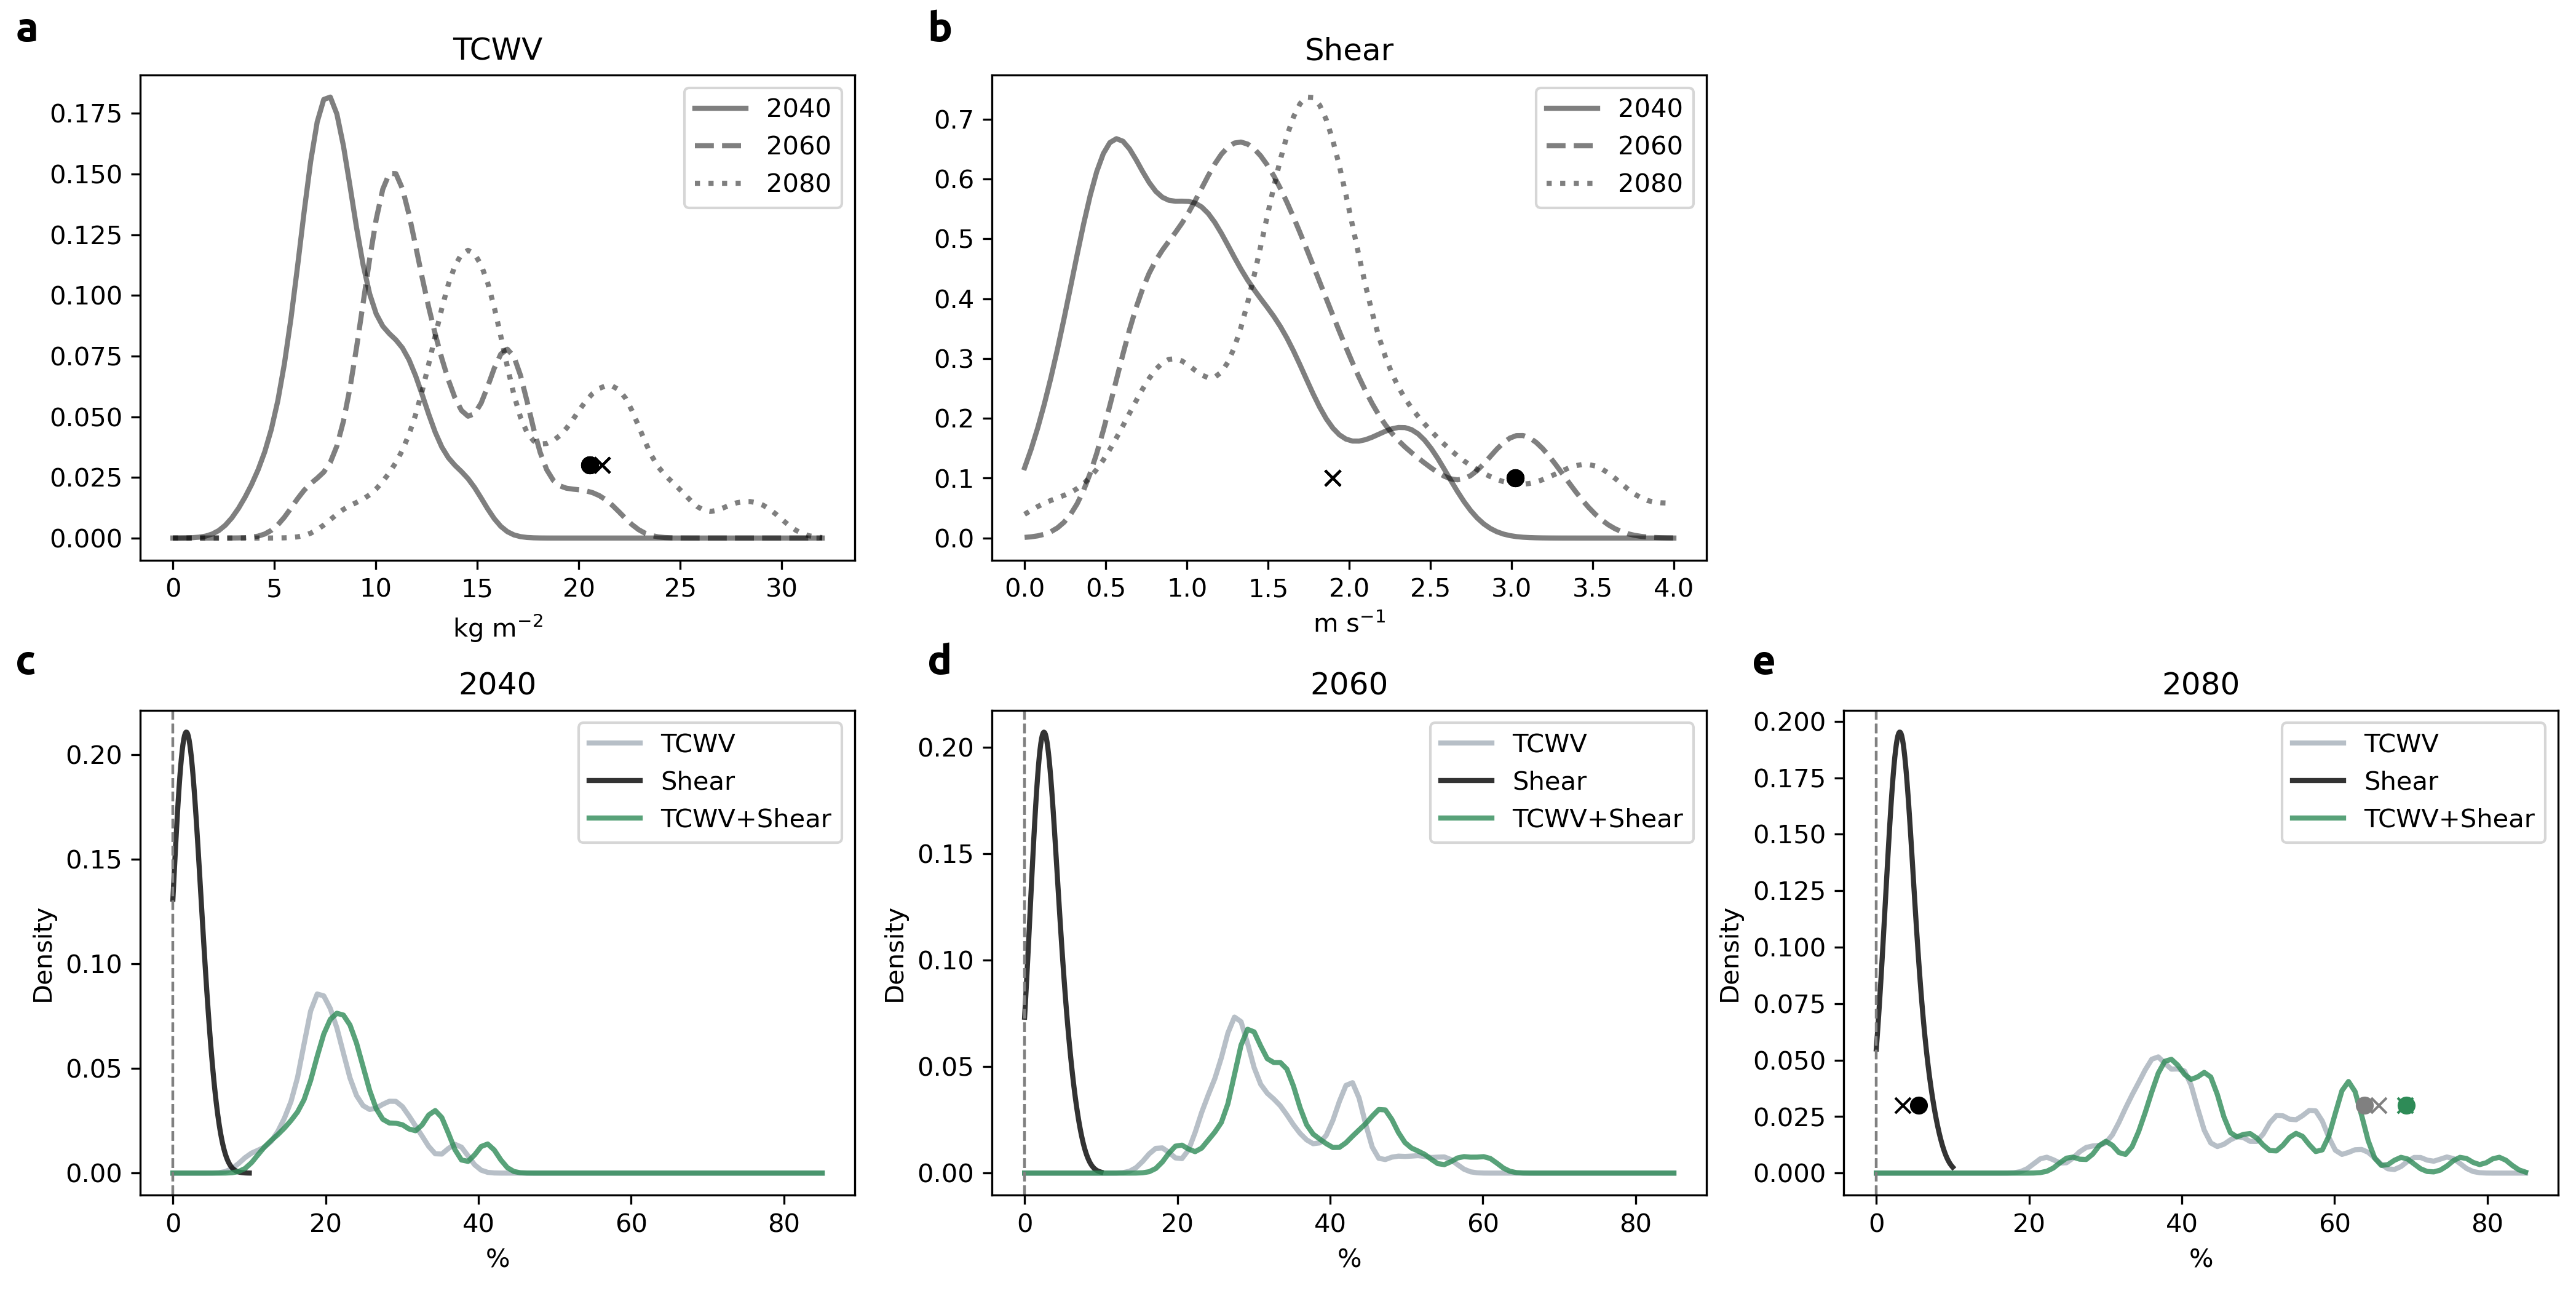

In [59]:

f = plt.figure(figsize=(14,7), dpi=300)
ax1 = f.add_subplot(2,3,1)
ax2 = f.add_subplot(2,3,2)


linestyle = ['solid', 'dashed', 'dotted']
for ids, stry in enumerate(['2040', '2060', '2080']):
    

    ##########

    x = ((cmip_read[stry])['tcw_mean']) * tcabsfac
    x_grid = np.linspace(0, 32, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=1)
    ax1.plot(x_grid, pdf, color='k', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
    ax1.set_title('TCWV')
    ax1.set_xlabel('kg m$^{-2}$')
    #ax1.axvline(0, linestyle='dashed', lw=1)
    
#     if ids == 2:
#         x = cmip_sahel_tcw.values[np.isfinite(cmip_sahel_tcw.values)]
#         x_grid = np.linspace(0, 25, 100)
#         pdf = kde_scipy(x, x_grid, bandwidth=1)
#         ax1.plot(x_grid, pdf, color='b', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
#         ax1.set_title('TCWV')
#         ax1.set_xlabel('kg m$^{-2}$')
#         #ax1.axvline(0, linestyle='dashed', lw=1)
        
    
    
    #
    x = (cmip_read[stry])['shear_mean']
    x_grid = np.linspace(0, 4, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=0.2)
    ax2.plot(x_grid, pdf, color='k', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
    ax2.set_title('Shear')
    ax2.set_xlabel('m s$^{-1}$')
    #plt.axvline(0, linestyle='dashed', lw=1)
    
#     if ids == 2:
        
#         x = cmip_sahel_sh.values[np.isfinite(cmip_sahel_sh.values)]
#         x_grid = np.linspace(-3, 1, 100)
#         pdf = kde_scipy(x, x_grid, bandwidth=0.2)
#         ax2.plot(x_grid, pdf, color='b', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
#         ax2.set_title('Shear')
#         ax2.set_xlabel('m s$^{-1}$')
#         #plt.axvline(0, linestyle='dashed', lw=1)
        
    ax1.plot(cp25_tcwv_diff,0.03, color='k', marker='x')
    ax1.plot(cp4_tcwv_diff,0.03, color='k', marker='o')
    #ax1.plot(cp4_sahel_tcw, 0.03, color='grey', marker='o')
    ax2.plot(cp25_shear_diff,0.1, color='k', marker='x')
    ax2.plot(cp4_shear_diff,0.1, color='k', marker='o')
    #ax2.plot(cp4_sahel_shear, 0.03, color='grey', marker='o')
        

    ax = f.add_subplot(2,3,ids+4)
    ##########
    #tcplot = hist2d.basic_1d_binning(cmip_tc_perc['2080'].values, np.arange(np.min(cmip_tc_perc['2080']), np.max(cmip_tc_perc['2080']),1))
    #ax.bar(tcplot['xbins'], tcplot['nb']/np.sum(tcplot['nb']), color='grey', label='TCWV')

    x = ((cmip_read[stry])['tcw_mean']) * tcabsfac  / mmPerPercent
    x_grid = np.linspace(0, 85, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=1.5)
    ax.plot(x_grid, pdf, color='slategrey', alpha=0.5, lw=2, label='TCWV')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #shplot = hist2d.basic_1d_binning(cmip_sh_precip['2080'].values, np.arange(np.min(cmip_sh_precip['2080']), np.max(cmip_sh_precip['2080']),0.1))
    #ax.bar(shplot['xbins'], shplot['nb']/np.sum(shplot['nb']), color='k', label='Shear', width=0.1)
    ##----
    x = ((cmip_read[stry])['shear_mean']) * shearfac / mmPerPercent
    x_grid = np.linspace(0, 10, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=1.5)
    ax.plot(x_grid, pdf, color='k', alpha=0.8, lw=2, label='Shear')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #stplot = hist2d.basic_1d_binning(cmip_shtc_precip[stry].values, np.arange(np.min(cmip_shtc_precip[stry]), np.max(cmip_shtc_precip[stry]),1))
    #ax.bar(stplot['xbins'], stplot['nb']/np.sum(stplot['nb']), color='seagreen', label='TCWV+Shear')
    ##----
    x = (((cmip_read[stry])['shear_mean']) * shearfac + ((cmip_read[stry])['tcw_mean']) * tcabsfac) / mmPerPercent
    x_grid = np.linspace(0, 85, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=1.5)
    ax.plot(x_grid, pdf, color='seagreen', alpha=0.8, lw=2,  label='TCWV+Shear')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')
    ##############
#     if ids == 2:
#         ax.plot(cp4_precip.loc['tcw', 'R25DELTA'],0.01, color='grey', marker='x')
#         ax.plot(cp4_precip.loc['tcw', 'CP4DELTA'],0.01, color='grey', marker='o')
#         ax.plot(cp4_precip.loc['shear', 'R25DELTA'],0.01, color='k', marker='x')
#         ax.plot(cp4_precip.loc['shear', 'CP4DELTA'],0.01, color='k', marker='o')
#         ax.plot(cp4_precip.loc['tcw', 'R25DELTA']+cp4_precip.loc['shear', 'R25DELTA'],0.01, color='seagreen', marker='x')
#         ax.plot(cp4_precip.loc['tcw', 'CP4DELTA']+cp4_precip.loc['shear', 'CP4DELTA'],0.01, color='seagreen', marker='o')
        
    if ids == 2:
        ax.plot(cp25_tcwv_diff * tcabsfac/ mmPerPercent,0.03, color='grey', marker='x')
        ax.plot(cp4_tcwv_diff * tcabsfac/ mmPerPercent,0.03, color='grey', marker='o')
        ax.plot(cp25_shear_diff* shearfac / mmPerPercent,0.03, color='k', marker='x')
        ax.plot(cp4_shear_diff* shearfac / mmPerPercent,0.03, color='k', marker='o')
        ax.plot((cp25_shear_diff * shearfac +  cp25_tcwv_diff * tcabsfac)/ mmPerPercent,0.03, color='seagreen', marker='x')
        ax.plot((cp4_shear_diff * shearfac +  cp4_tcwv_diff * tcabsfac)/ mmPerPercent,0.03, color='seagreen', marker='o')

    plt.xlabel('%')
    plt.ylabel('Density')

    plt.title(stry)

    plt.legend()
ax1.legend()
ax2.legend()
plt.tight_layout()

text = ['a', 'b', 'c', 'd', 'e']
plt.annotate(text[0], xy=(0.006, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.36, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.006, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.36, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[4], xy=(0.68, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)

plt.savefig(cnst.network_data + 'figs/ENDGAME/CMIP_driver_PDF_Sahelonly.png')

NameError: name 'cmip_tc_diff' is not defined

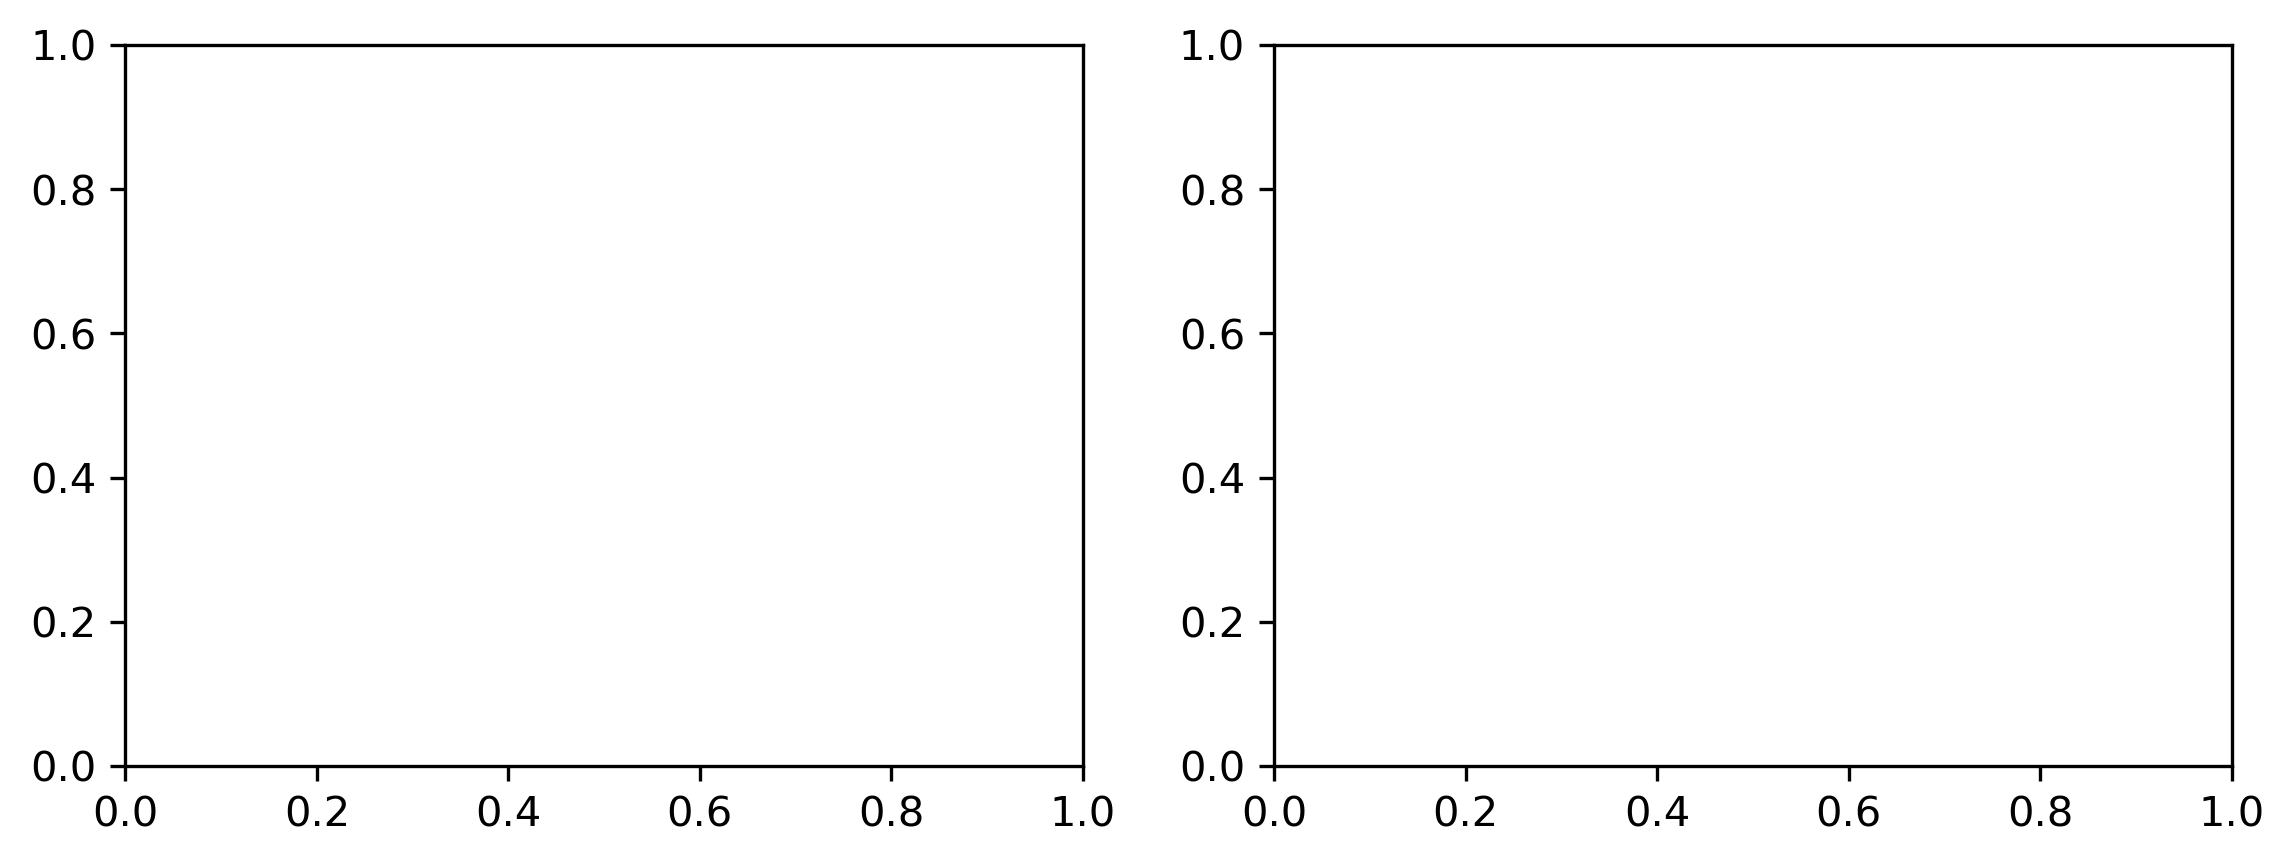

In [30]:
f = plt.figure(figsize=(14,7), dpi=300)
ax1 = f.add_subplot(2,3,1)
ax2 = f.add_subplot(2,3,2)

mk=3
linestyle = ['solid', 'dashed', 'dotted']
for ids, stry in enumerate(['2040', '2060', '2080']):
    

    ##########
    x = cmip_tc_diff[stry].values[np.isfinite(cmip_tc_diff[stry].values)]
    cumulative = np.sort(x)

    ax1.plot(cumulative, np.arange(len(cumulative))+1, label=stry, marker='o', markersize=mk, color='k', linestyle=linestyle[ids])
    #ax1.plot(x_grid, pdf, color='k', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
    ax1.set_title('TCWV')
    ax1.set_xlabel('kg m$^{-2}$')
    ax1.set_ylabel('Model number')

    ax1.plot(cp4_diff.loc['tcw', 'R25DELTA'],0.03, color='k', marker='x')
    ax1.plot(cp4_diff.loc['tcw', 'CP4DELTA'],0.03, color='k', marker='o')
    ax2.plot(cp4_diff.loc['shear', 'R25DELTA'],0.03, color='k', marker='x')
    ax2.plot(cp4_diff.loc['shear', 'CP4DELTA'],0.03, color='k', marker='o')

    #ax1.axvline(0, linestyle='dashed', lw=1)
    
    
    #
    x = cmip_sh_diff[stry].values[np.isfinite(cmip_sh_diff[stry].values)]
    cumulative = np.sort(x)

    ax2.plot(cumulative, np.arange(len(cumulative))+1, label=stry, marker='o', markersize=mk, color='k', linestyle=linestyle[ids])
    ax2.set_title('Shear')
    ax2.set_xlabel('m s$^{-1}$')
    ax2.set_ylabel('Model number')
    #plt.axvline(0, linestyle='dashed', lw=1)

    ax = f.add_subplot(2,3,ids+4)
    ##########
    x = cmip_tc_perc[stry].values[np.isfinite(cmip_tc_perc[stry].values)]
    cumulative = np.sort(x)

    ax.plot(cumulative, np.arange(len(cumulative))+1, color='slategrey', alpha=0.5, lw=2, label='TCWV', marker='o', markersize=mk, linestyle='solid')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #shplot = hist2d.basic_1d_binning(cmip_sh_precip['2080'].values, np.arange(np.min(cmip_sh_precip['2080']), np.max(cmip_sh_precip['2080']),0.1))
    #ax.bar(shplot['xbins'], shplot['nb']/np.sum(shplot['nb']), color='k', label='Shear', width=0.1)
    ##----
    x = cmip_sh_perc[stry].values[np.isfinite(cmip_sh_perc[stry].values)]
    cumulative = np.sort(x)
    ax.plot(cumulative, np.arange(len(cumulative))+1, color='k', alpha=0.8, lw=2, label='Shear', marker='o', markersize=mk, linestyle='solid')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #stplot = hist2d.basic_1d_binning(cmip_shtc_precip[stry].values, np.arange(np.min(cmip_shtc_precip[stry]), np.max(cmip_shtc_precip[stry]),1))
    #ax.bar(stplot['xbins'], stplot['nb']/np.sum(stplot['nb']), color='seagreen', label='TCWV+Shear')
    ##----
    x = cmip_shtc_precip[stry].values[np.isfinite(cmip_shtc_precip[stry].values)]
    cumulative = np.sort(x)
    
    ax.plot(cumulative, np.arange(len(cumulative))+1, color='seagreen', alpha=0.8, lw=2,  label='TCWV+Shear', marker='o', markersize=mk, linestyle='solid')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')
    ##############
    if ids == 2:
        ax.plot(cp4_precip.loc['tcw', 'R25DELTA'],0.03, color='grey', marker='x')
        ax.plot(cp4_precip.loc['tcw', 'CP4DELTA'],0.03, color='grey', marker='o')
        ax.plot(cp4_precip.loc['shear', 'R25DELTA'],0.03, color='k', marker='x')
        ax.plot(cp4_precip.loc['shear', 'CP4DELTA'],0.03, color='k', marker='o')
        ax.plot(cp4_precip.loc['tcw', 'R25DELTA']+cp4_precip.loc['shear', 'R25DELTA'],0.03, color='seagreen', marker='x')
        ax.plot(cp4_precip.loc['tcw', 'CP4DELTA']+cp4_precip.loc['shear', 'CP4DELTA'],0.03, color='seagreen', marker='o')
   
    plt.xlabel('%')
    plt.ylabel('Model number')

    plt.title(stry)
    if ids == 0:
        plt.legend()
ax1.legend()
#ax2.legend()

#ipdb.set_trace()

text = ['a', 'b', 'c', 'd', 'e']
plt.annotate(text[0], xy=(0.006, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.36, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.006, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.36, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[4], xy=(0.68, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/ENDGAME/CMIP_driver_marker+uncertainty.png')